In [23]:
import numpy as np
import pandas as pd

# Parameters
sampling_rate = 100  # Hz (samples per second)
duration_normal = 10 * 60  # 10 minutes of normal data
duration_earthquake = 2 * 60  # 2 minutes of earthquake data
gravity = 9.81  # Gravity in m/s²

# Total samples for each condition
samples_normal = sampling_rate * duration_normal
samples_earthquake = sampling_rate * duration_earthquake

# Function to generate realistic sensor data
def generate_sensor_data(num_samples, condition="normal"):
    if condition == "normal":
        # Normal condition: low noise, steady accelerometer data
        accel_data = np.random.normal([0, 0, gravity], [0.1, 0.1, 0.05], (num_samples, 3))  # Accelerometer (Ax, Ay, Az)
        gyro_data = np.random.normal(0, 0.01, (num_samples, 3))  # Gyroscope (Gx, Gy, Gz)

    elif condition == "earthquake":
        # Earthquake condition: spikes and large variations
        accel_data = np.random.normal([0, 0, gravity], [2, 2, 2], (num_samples, 3))  # Accelerometer
        gyro_data = np.random.normal(0, 0.5, (num_samples, 3))  # Gyroscope

        # Add random spikes to simulate earthquake tremors
        spike_indices = np.random.choice(num_samples, size=int(num_samples * 0.1), replace=False)
        accel_data[spike_indices] += np.random.normal(0, 5, (len(spike_indices), 3))  # Spikes in accelerometer
        gyro_data[spike_indices] += np.random.normal(0, 2, (len(spike_indices), 3))  # Spikes in gyroscope

    return accel_data, gyro_data

# Define the balanced sample size
balanced_sample_size = min(samples_normal, samples_earthquake)

# Generate data for normal condition (limited to balanced sample size)
accel_normal, gyro_normal = generate_sensor_data(balanced_sample_size, "normal")

# Generate data for earthquake condition (limited to balanced sample size)
accel_earthquake, gyro_earthquake = generate_sensor_data(balanced_sample_size, "earthquake")

# Concatenate accelerometer and gyroscope data
accel_data = np.vstack((accel_normal, accel_earthquake))
gyro_data = np.vstack((gyro_normal, gyro_earthquake))

# Create labels (0 for normal, 1 for earthquake)
labels = np.hstack((np.zeros(balanced_sample_size), np.ones(balanced_sample_size)))

# Create a DataFrame
data = pd.DataFrame({
    'Ax': accel_data[:, 0],
    'Ay': accel_data[:, 1],
    'Az': accel_data[:, 2],
    'Gx': gyro_data[:, 0],
    'Gy': gyro_data[:, 1],
    'Gz': gyro_data[:, 2],
    'Label': labels
})

# Save to CSV
csv_filename = 'balanced_earthquake_dataset.csv'
data.to_csv(csv_filename, index=False)

print(f"Balanced dataset saved as {csv_filename}.")


Balanced dataset saved as balanced_earthquake_dataset.csv.


In [24]:
import numpy as np
import pandas as pd

def generate_synthetic_test_data(num_samples=1000):
    # Parameters
    num_features = 6  # Number of features (Ax, Ay, Az, Gx, Gy, Gz)

    # Generate random feature data
    X_test = np.random.normal(loc=0, scale=1, size=(num_samples, num_features))

    # Generate synthetic labels
    # Assume 10% of the samples are positive (earthquake)
    y_test = np.random.binomial(1, 0.1, size=num_samples)

    # Create DataFrame
    df_test = pd.DataFrame(X_test, columns=['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz'])
    df_test['Label'] = y_test

    return df_test

# Generate and save synthetic test dataset
synthetic_test_data = generate_synthetic_test_data(num_samples=1000)
synthetic_test_data.to_csv('synthetic_test_data.csv', index=False)

print("Synthetic test dataset created and saved as 'synthetic_test_data.csv'.")


Synthetic test dataset created and saved as 'synthetic_test_data.csv'.


In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the original dataset
data = pd.read_csv('/content/balanced_earthquake_dataset.csv')

# Features and target
X = data[['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']].values
y = data['Label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
# Save the model
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

# Train XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Train SVM
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
# Save the model
joblib.dump(svm_model, 'svm_model.pkl')

# Train LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, verbose=1)
# Save the model
lstm_model.save('lstm_model.h5')

print("Models trained and saved.")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7567 - loss: 0.6597
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9398 - loss: 0.3288
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9789 - loss: 0.1134
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9887 - loss: 0.0566
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9928 - loss: 0.0354
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9948 - loss: 0.0261
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9962 - loss: 0.0182
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9972 - loss: 0.0144
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9972 - loss: 0.0121
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9970 - loss: 0.0106


Models trained and saved.


In [26]:
import joblib
from keras.models import load_model

# Load the models
rf_model = joblib.load('rf_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
svm_model = joblib.load('svm_model.pkl')
lstm_model = load_model('lstm_model.h5')


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_on_test_data(model, X_test, y_test, is_lstm=False):
    if is_lstm:
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels
    else:
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate Random Forest
rf_metrics = evaluate_on_test_data(rf_model, X_test_scaled, y_test)
rf_synthetic_metrics = evaluate_on_test_data(rf_model, X_test_synthetic, y_test_synthetic)

# Evaluate XGBoost
xgb_metrics = evaluate_on_test_data(xgb_model, X_test_scaled, y_test)
xgb_synthetic_metrics = evaluate_on_test_data(xgb_model, X_test_synthetic, y_test_synthetic)

# Evaluate SVM
svm_metrics = evaluate_on_test_data(svm_model, X_test_scaled, y_test)
svm_synthetic_metrics = evaluate_on_test_data(svm_model, X_test_synthetic, y_test_synthetic)

# Evaluate LSTM
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_test_synthetic_lstm = X_test_synthetic.reshape((X_test_synthetic.shape[0], 1, X_test_synthetic.shape[1]))

lstm_metrics = evaluate_on_test_data(lstm_model, X_test_lstm, y_test, is_lstm=True)
lstm_synthetic_metrics = evaluate_on_test_data(lstm_model, X_test_synthetic_lstm, y_test_synthetic, is_lstm=True)


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


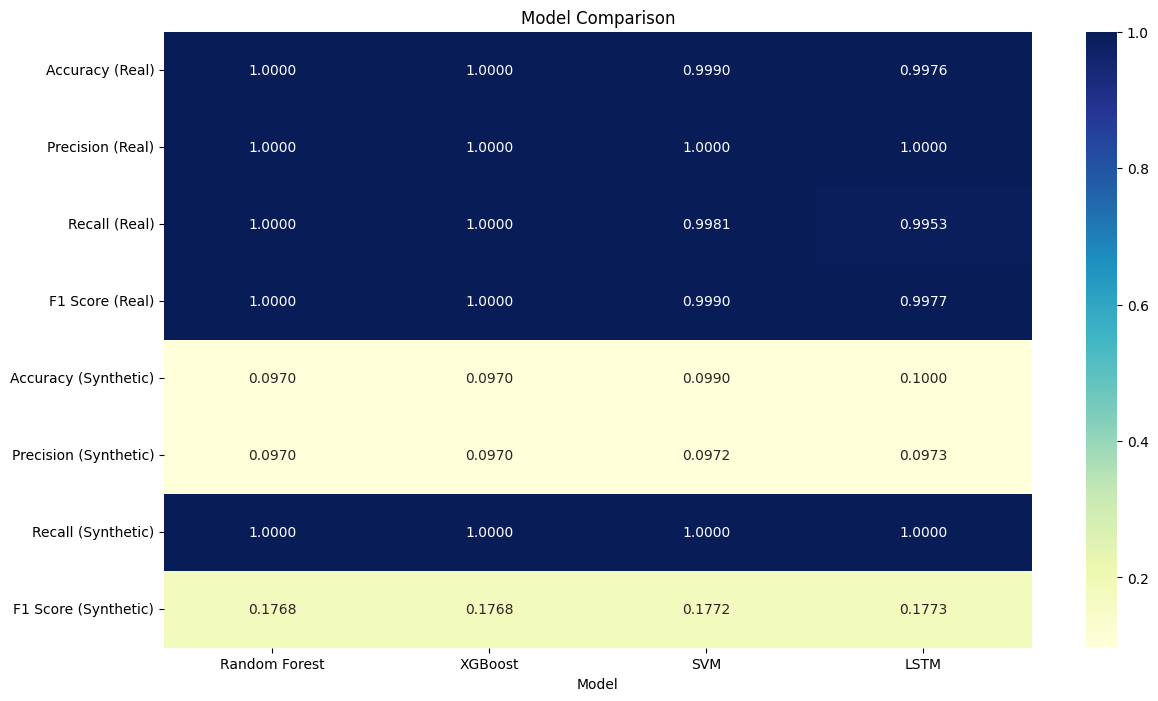

           Model  Accuracy (Real)  Precision (Real)  Recall (Real)  \
0  Random Forest         1.000000               1.0       1.000000   
1        XGBoost         1.000000               1.0       1.000000   
2            SVM         0.999028               1.0       0.998073   
3           LSTM         0.997639               1.0       0.995319   

   F1 Score (Real)  Accuracy (Synthetic)  Precision (Synthetic)  \
0         1.000000                 0.097               0.097000   
1         1.000000                 0.097               0.097000   
2         0.999035                 0.099               0.097194   
3         0.997654                 0.100               0.097292   

   Recall (Synthetic)  F1 Score (Synthetic)  
0                 1.0              0.176846  
1                 1.0              0.176846  
2                 1.0              0.177169  
3                 1.0              0.177331  


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame to compare models
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'SVM', 'LSTM'],
    'Accuracy (Real)': [rf_metrics[0], xgb_metrics[0], svm_metrics[0], lstm_metrics[0]],
    'Precision (Real)': [rf_metrics[1], xgb_metrics[1], svm_metrics[1], lstm_metrics[1]],
    'Recall (Real)': [rf_metrics[2], xgb_metrics[2], svm_metrics[2], lstm_metrics[2]],
    'F1 Score (Real)': [rf_metrics[3], xgb_metrics[3], svm_metrics[3], lstm_metrics[3]],
    'Accuracy (Synthetic)': [rf_synthetic_metrics[0], xgb_synthetic_metrics[0], svm_synthetic_metrics[0], lstm_synthetic_metrics[0]],
    'Precision (Synthetic)': [rf_synthetic_metrics[1], xgb_synthetic_metrics[1], svm_synthetic_metrics[1], lstm_synthetic_metrics[1]],
    'Recall (Synthetic)': [rf_synthetic_metrics[2], xgb_synthetic_metrics[2], svm_synthetic_metrics[2], lstm_synthetic_metrics[2]],
    'F1 Score (Synthetic)': [rf_synthetic_metrics[3], xgb_synthetic_metrics[3], svm_synthetic_metrics[3], lstm_synthetic_metrics[3]],
})

# Plot the comparison table
plt.figure(figsize=(14, 8))
sns.heatmap(metrics_df.set_index('Model').T, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Model Comparison')
plt.show()

# Print the metrics DataFrame
print(metrics_df)
